## Setup

In [27]:
import math

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

/home/012392471/miniconda3/envs/security/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading in Data

For this project, we are using a dataset from Kaggle containing 651,191 URLs and 4 classes (benign, defacement, phishing, and malware) [1]. Benign URLs are not malicious. Defacement URLs refer to trusted websites being hacked to include malicious content [2].

The URLs were gathered from multiple sources: an ISCX-URL2016 dataset from University of New Brunswick, a Phishtank dataset, a PhishStorm dataset, and a dataset of benign URLs from a git repository [1].

In [120]:
original_df = pd.read_csv("malicious_phish.csv")
original_df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


The class imbalance is shown below, with benign URLs consisting of the majority of the data points. Defacement and malware take second place, and phishing URLs consist of the smallest percentage of URLs.

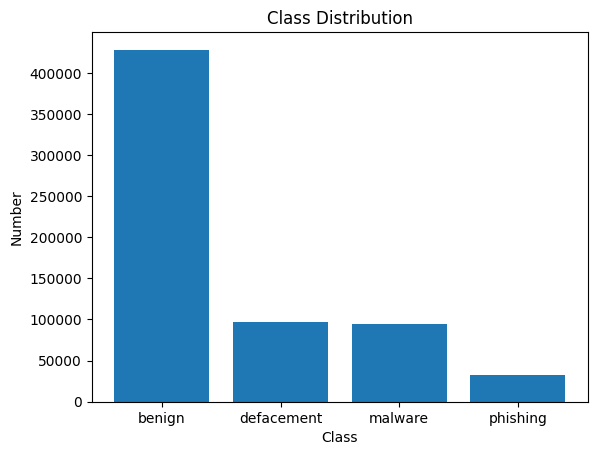

In [121]:
plt.bar(["benign", "defacement", "malware", "phishing"], [428103, 96547, 94111, 32520])
plt.xlabel("Class")
plt.ylabel("Number")
plt.title("Class Distribution")
plt.show()

The cell below is one method for dealing with a class imbalance. This imbalance results from the fact that malicious URLs are rare and uncommon. The code groups up the rows by their class (benign, defacement, etc.) and sums up the counts for each class [3]. The division by 1 normalizes the counts. [3]

In [122]:
weights = 1.0 / original_df.groupby('type')['type'].transform('count')

In [123]:
weights.head()

0    0.000011
1    0.000002
2    0.000002
3    0.000010
4    0.000010
Name: type, dtype: float64

## Sampling the Data

I am taking a sample of the data to use in order to reduce computational complexity.

There are two methods shown below. The first method uses a percentage, while the other method uses an explicit number of samples.

I am also including the `weights` array I declared above to equally sample from all 4 classes.

In [124]:
# PERCENTAGE = 0.005
# df = original_df.sample(frac=PERCENTAGE, replace=False, random_state=42)

In [125]:
NUM_SAMPLES = 1000
df = original_df.sample(n=NUM_SAMPLES, replace=False, random_state=42, weights=weights)

In [126]:
df.shape

(1000, 2)

These cells below show the equalized class distribution. I created a dictionary object to store the counts for each class.

In [127]:
cnts = {"benign": 0, "defacement": 0, "phishing": 0, "malware": 0}
for ele in df["type"]:
    cnts[ele] += 1
print(cnts)

{'benign': 268, 'defacement': 251, 'phishing': 232, 'malware': 249}


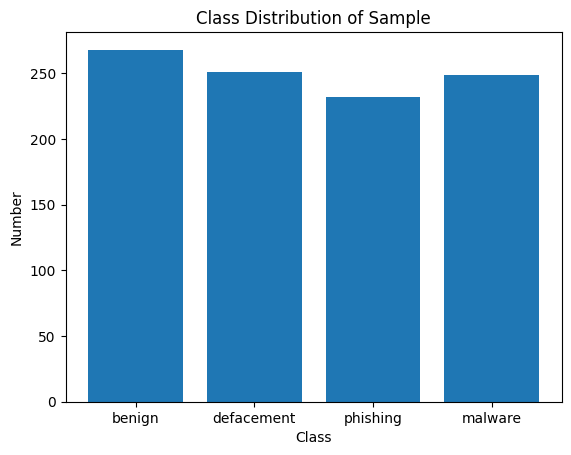

In [128]:
plt.bar(cnts.keys(), cnts.values())
plt.xlabel("Class")
plt.ylabel("Number")
plt.title("Class Distribution of Sample")
plt.show()

## BERT Setup

I am loading the pre-trained model along with its tokenizer here.

BERT (Bi-Directional Pre-Trained Transformer) uses the encoder part of a transformer. This model is pre-trained under the MLM (masked language modeling) task on lots of data from the Internet. Therefore, the model has a good understanding of English grammar by learning how to fill in the blanks for the sentences it takes in.

BERT is not trained in the classification task I want to perform, so I need to perform **fine-tuning** for BERT on a sample of the URL data.

This model does not need a large amount of data to fine-tune, since it already has an excellent understanding of English grammar and context.

Each model has its own tokenizer because they each accept data in their own specific formats.

I am running this model on the SJSU HPC (High-Performance Cluster) servers, so I had to download the model from HuggingFace to use locally. 

In [129]:
MODEL = "./bert-base-uncased/"

In [130]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [131]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./bert-base-uncased/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Loading Dataset

Currently, the dataset is loaded into a Pandas dataframe. It has to be loaded into a HuggingFace Dataset format in order to be compatible with the HuggingFace model.

In [132]:
def convert_to_HF(df):
    dataset = Dataset.from_pandas(df)
    if "__index_level_0__" in list(dataset.features.keys()):
        dataset = dataset.remove_columns(["__index_level_0__"])
    dataset = dataset.class_encode_column("type")
    
    dataset = dataset.rename_column("url", "text")
    dataset = dataset.rename_column("type", "label")

    return dataset

BERT also expects the columns to be named "text" and "label".

In [133]:
dataset = convert_to_HF(df)

Casting to class labels: 100%|███| 1000/1000 [00:00<00:00, 141108.33 examples/s]


Here I am getting the label names for the confusion matrix and classification report for the evaluation stage.

In [134]:
target_labels = dataset.features["label"].names

In [135]:
target_labels

['benign', 'defacement', 'malware', 'phishing']

In [136]:
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

## BERT Tokenization

The URLs need to be converted into numbers, so I use the BERT tokenizer here to convert the inputs into a format that BERT can recognize.

BERT uses a WordPiece tokenizer [4]. It uses the following formula to figure out what tokens pairs to merge together [4]:
$$
\text{score} = \frac{\text{freq\_of\_pair}}{\text{freq\_of\_first\_element} \times \text{freq\_of\_second\_element}}
$$

It creates a library of tokens so that i can generalize to unseen words [4].

The formula above differentiates it from a more classic tokenization algorithm called BPE (byte-pair encoding), which only looks at the frequencies of token pairs [4].

In [137]:
def tokenize(data):
    return tokenizer(data["text"], padding="max_length", return_tensors="pt")

In [138]:
tokenized_dataset = dataset.map(tokenize, batched=True)

Map: 100%|█████████████████████████| 1000/1000 [00:00<00:00, 2729.71 examples/s]


In [139]:
tokenized_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

## Dataset Split

I am splitting the dataset here into **train**, **validation**, and **test** sets.

In [140]:
split_dataset = tokenized_dataset.train_test_split(test_size=0.1)

In [141]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 900
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 100
    })
})

In [142]:
train_eval_dataset = split_dataset["train"]

In [143]:
train_eval_split_dataset = train_eval_dataset.train_test_split(test_size=0.1)

Below are the three variables holding the data splits.

In [144]:
train_dataset = train_eval_split_dataset["train"]

In [145]:
eval_dataset = train_eval_split_dataset["test"]

In [146]:
test_dataset = split_dataset["test"]

Here you can see the number of data points for each data split.

In [147]:
train_dataset, eval_dataset, test_dataset

(Dataset({
     features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 810
 }),
 Dataset({
     features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 90
 }),
 Dataset({
     features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 100
 }))

## BERT Fine-Tuning

This object specifies the training configuration arguments.

The `output_dir` parameter specifies the directory where the model checkpoints will be stored. Model checkpoints store the model weights at predefined increments. 

The `num_train_epochs` parameter specifies the number of epochs that the model will train for. Each epoch goes through all of the batches of training data.

The `learning_rate` parameter controls how fast or how slow the model will learn. A higher learning rate will cause the model to converge faster, but a slower learning rate will slow down the model learning and lessen overfitting.

The `per_device_train_batch_size` parameter controls how large each batch of data is. 

In [148]:
training_args = TrainingArguments(output_dir="results", 
                                  num_train_epochs=5,
                                  logging_steps=1,
                                  learning_rate=5e-5,
                                  per_device_train_batch_size=8,
                                  weight_decay=0,
                                  evaluation_strategy="epoch")

I am using cross-entropy loss here because this is a multi-class classification problem. It compares the predicted probability distribution with the actual probability distribution and measures how close your predictions are. This provides more fine-grained tuning with probabilities.

In [149]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    sum = 0
    for i in range(len(labels)):
        raw_logits = logits[i]

        # softmax calculation
        exp_logits = np.exp(raw_logits)
        norm_logits = exp_logits / np.sum(exp_logits, axis=0)
        chosen_value = norm_logits[labels[i]]

        # calculating the log of the probabilities
        sum += np.log(chosen_value)
    sum /= -len(labels)
    return {"cross_entropy": sum}

In [150]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

/home/012392471/miniconda3/envs/security/lib/python3.12/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [151]:
trainer.train()

Epoch,Training Loss,Validation Loss,Cross Entropy
1,0.062000,0.531213,0.531213
2,0.043900,0.506172,0.506172
3,0.027400,0.545509,0.545509
4,0.004600,0.499624,0.499624
5,0.003500,0.452084,0.452085


TrainOutput(global_step=510, training_loss=0.3429821028465442, metrics={'train_runtime': 253.2266, 'train_samples_per_second': 15.994, 'train_steps_per_second': 2.014, 'total_flos': 1065618909388800.0, 'train_loss': 0.3429821028465442, 'epoch': 5.0})

## Predictions

Now we perform prediction on the test dataset we put aside.

In [152]:
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)

In [153]:
true_labels = test_dataset["label"]

In [154]:
conf_mat = confusion_matrix(true_labels, predicted_labels, labels=np.arange(4))

It is important to see how the model performs across the different classes. A single accuracy value averaged across all of the classes provides an insufficient evaluation of the model's performance. As mentioned earlier, there is a class imbalance. If the model boasts an accuracy of 90%, it does not provide information on the under-represented classes. Therefore, it is vital to look at the precision, recall, and F-1 score for each class. These metrics are detailed in the classification report below.

Precision measures the confidence of the model’s predictions. Recall measures how many positive class samples were correctly identified by the model. F-1 score is the harmonic mean of both precision and recall.

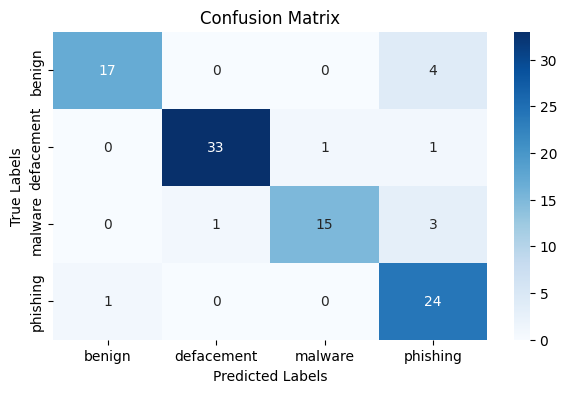

In [155]:
plt.figure(figsize=(7, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

The classification report below shows precision, recall, F-1 score, and support for each class. Support is the number of occurences of each class in the dataset.

In [156]:
report = classification_report(true_labels, predicted_labels, labels=np.arange(4), target_names=target_labels, output_dict=False)
print(report)

              precision    recall  f1-score   support

      benign       0.94      0.81      0.87        21
  defacement       0.97      0.94      0.96        35
     malware       0.94      0.79      0.86        19
    phishing       0.75      0.96      0.84        25

    accuracy                           0.89       100
   macro avg       0.90      0.88      0.88       100
weighted avg       0.90      0.89      0.89       100



# Results


The cells below show the F-1 scores for malware classification for a few parameters, namely `learning_rate` and `batch_size`. The table illustrations are derived from the code on this site [5].

In [31]:
def createFigure(df, title):
    #initialize figure
    fig = plt.figure(figsize = (6, .4))
    ax = fig.add_subplot(111)
    
    #create table
    ax.table(cellText = df.values, rowLabels = df.index, 
             colLabels = df.columns, cellLoc='center')
    
    #add title to table
    ax.set_title(title)
    
    #turn axes off
    ax.axis('off')

A learning rate of 5e-5 is the best for both imbalanced and balanced data. A low learning rate underfits by taking too long to converge, while a high learning rate overfits by converging too fast.

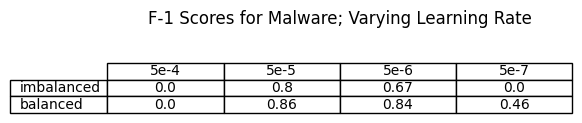

In [32]:
d_lr = {
    "5e-4": [0.00, 0.00],
    "5e-5": [0.80, 0.86],
    "5e-6": [0.67, 0.84],
    "5e-7": [0.00, 0.46]
}

lr_df = pd.DataFrame(d_lr, index=["imbalanced", "balanced"])
createFigure(lr_df, "F-1 Scores for Malware; Varying Learning Rate")

A batch size of 8 is better for imbalanced data, while a batch size of 4 is better for balanced data. This may be the case because imbalanced data needs more samples per batch to train better.

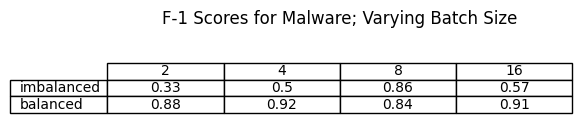

In [33]:
d_batch_size = {
    "2": [0.33, 0.88],
    "4": [0.50, 0.92],
    "8": [0.86, 0.84],
    "16": [0.57, 0.91]
}

batch_size_df = pd.DataFrame(d_batch_size, index=["imbalanced", "balanced"])
createFigure(batch_size_df, "F-1 Scores for Malware; Varying Batch Size")

In conclusion, BERT takes more computational power but can learn better with less samples. It removes the overhead of manually creating tokens or hand-engineered features. The main advantage to this method is the ability to generalize. However, it misses out on additional info, such as DNS/host information or webpage content.

For future work, I hope to try out different BERT models from HuggingFace  to try to improve performance. I will also try out additional hyperparameter optimizers, like LoRA (low rank adaptation) or Bayesian optimizers.


# References

[1] https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset

[2] https://www.unb.ca/cic/datasets/url-2016.html

[3] https://stackoverflow.com/questions/55042334/pandas-sample-with-weights 

[4] https://huggingface.co/learn/nlp-course/en/chapter6/6

[5] https://scales.arabpsychology.com/stats/how-to-add-title-to-pandas-dataframe/

# Malicious URL Analysis Using Classification

## Abstract
The purpose of this exploration was to determine if an AI classification model could be used to determine whether a URL is malicious or not. To perform this analysis, the machine learning tool scikit-learn was used with pandas, matplotlib, and seaborn used for result visualization. The dataset used is by Manu Siddhartha consisting of 650,000 URLs classified into 4 categories: Benign, Defacement, Phishing, and Malware. For the purposes of testing efficiency, a 150,000 portion of the complete dataset were randomly selected at the start of each iteration. The machine learning models used to classify the URLs were SVM (Support Vector Machine), Random Forest, and K-Nearest Neighbors (KNN). All these models specialize in classification problems such as this one. To obtain predefined data, URLs were analyzed using 7 main features. After the analysis, 30% of the analyzed data were randomly selected for model training. The results from multiple iterations showed Random Forest performed the best among the 3 models with higher precision, true positive rates, and true negative rates across all types. SVM and KNN both performed equally. Both models had minimal differences in terms of accuracy and precision metrics. The highest achieved accuracy was by random forest with an accuracy of about 92%. It is important to note that this general accuracy is subject to scrutiny since this accuracy does not take into account the number of types in each category. Future research would need to include different models and more features to analyze to filter down to the most important ones. In conclusion, this exploration demonstrated that it is possible to know whether a URL is malicious and that random forest was the most effective out of the 3 models tested, but it is difficult to surmise the type of maliciousness from the URL alone.

Keywords-Classification, Python, Artificial Intelligence, AI, Security, Cybersecurity, URL, Uniform Resource Locator

### Introduction

Classification models in AI specialize in finding patterns in data and accurately placing data into set categories. Of the possible ways to utilize classification models, this research will focus on identifying and classifying potentially malicious URLs (Uniform Resource Locators) such as phishing, malware, and defacement to protect users against such online threats. Additionally, this process would also reduce the time and effort a system administrator would have to take to manual intervention against such threats. 

Traditional methods of guarding against harmful web pages rely on manual intervention of classifying URLs through hands-on detection and remediation in the form of blacklists and firewall rules. However, given the growth and increasing sophistication of threats on the web, the practicality of such work given the time expended should be called into question. 

To address these challenges, classification models can be used to categorize URLs into either benign or malicious URLs. In this study, three popular algorithms were employed: Support Vector Machines (SVM), Random Forest, and K-Nearest Neighbors (KNN). These algorithms work well in classification tasks and have been used in a variety of domains both in and out of cybersecurity. 

As an overview, SVM works by computing the hyperplane that best separates different classes of data points to maximize the distance between them. Random forest creates decision trees during training and uses these as the basis for classification. Lastly, KNN classifies objects based on the relative distance from other classes in the feature space.

To evaluate the effectiveness of these algorithms, a dataset of 650,000 URLS were obtained with 4 distinct categories: Benign, Defacement, Phishing, and Malware. Benign URLs are harmless, defacement URLs contain modified content similar to a benign site, phishing URLs lead to sites that attempt to phish for user data, and malware URLs contain malicious code intended for a user's computer. These algorithms were each benchmarked against each other using a random subset of the full dataset and each algorithm used the same random set. 

The goal of this research is to develop a robust and automated system capable of accurately identifying malicious URLs, which would both reduce the risk and effort that would be otherwise taken by cybersecurity professionals. 

In [1]:
# install dependencies
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install tldextract
%pip install matplotlib
%pip install seaborn
%pip install pickle


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import re
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tldextract as tlde

In [3]:
#load data and check if valid
NUM_SAMPLES = 150000
df = pd.read_csv("malicious_phish.csv")
df = df.sample(n=NUM_SAMPLES, replace=False, random_state=51)
df.head()
df.shape

(150000, 2)

In [4]:
df.isnull().sum()

url     0
type    0
dtype: int64

In [5]:
type_counts = df["type"].value_counts()
type_counts

type
benign        98466
defacement    22188
phishing      21841
malware        7505
Name: count, dtype: int64

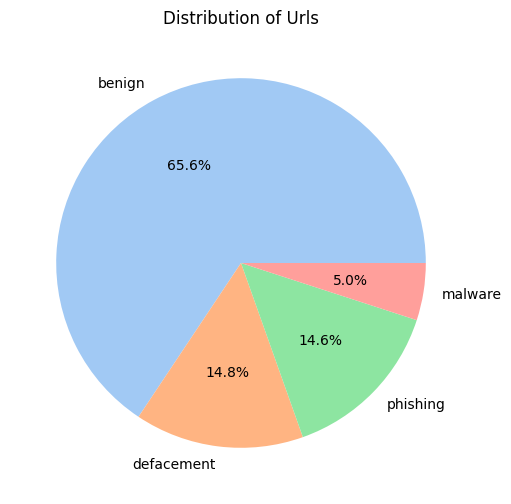

In [6]:
# display distribution
plt.figure(figsize=(6, 6))
plt.pie(
    type_counts,
    labels=type_counts.index,
    autopct="%1.1f%%", # percentage formatting
    colors=sns.color_palette("pastel"),
)
plt.title("Distribution of Urls")
plt.show()


In [7]:
# remove www. from all URLs
df["url"] = df["url"].str.replace("www", "")
df.head()


,url,type
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign
64374,kvha.org/,benign


## Methods
Each category of URL was mapped to a number 0-3. These numbers make it easier for the classification models used later to classify these URLs. There were a total of 7 major categories: URL length, Presence in Alexa's Top 1000 domains, HTTP or HTTPS status, Frequency of special characters, Digit-to-letter ratio, whether or not the domain contains an IP, and whether or not the domain has been shortened by a service. These categories were computed and transformed into values that an ML model could understand and placed in a Pandas DataFrame. 3 models from SciKitLearn were used for this analysis, Support Vector Machine, Random Forest, and K-Nearest Neighbors. The data used for training and testing were the same across all 3 models and the original data was randomized to ensure no bias in the structure of the data. A total of 150,000 data points were selected and 30% were selected for testing while 70% of the data were selected for training. After training and testing each model, statistics were recorded using a confusion matrix and accuracy calculations.

In [8]:
# create categories and add it to the data frame
url_categories = {
    "benign": 0,
    "phishing": 1,
    "defacement": 2,
    "malware": 3
}

df["category"] = df["type"].map(url_categories)

df.head()

,url,type,category
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign,0
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign,0
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign,0
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign,0
64374,kvha.org/,benign,0


In [9]:
# Analyze if there exists a relationship between URL length and being a non-benign URL
df["url_length"] = df["url"].apply(len)

df.head()

,url,type,category,url_length
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign,0,45
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign,0,107
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign,0,201
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign,0,89
64374,kvha.org/,benign,0,9


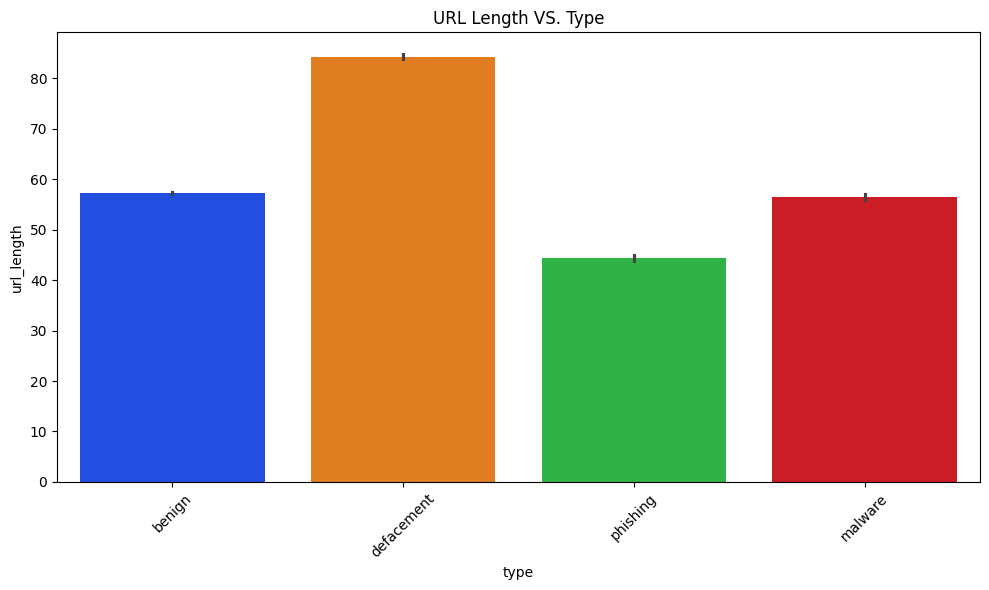

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="type", y="url_length", palette="bright", hue="type")
plt.title("URL Length VS. Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We can see here that past the cutoff point of a length of about 60, every URL is likely defacement for this dataset.

In [11]:
# Extract domain and suffix from url
def extract_domain(url: str):
    extracted_url = tlde.extract(url)
    return f"{extracted_url.domain}.{extracted_url.suffix}"

df["domain"] = df["url"].apply(extract_domain)

df.head()

,url,type,category,url_length,domain
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign,0,45,go.com
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign,0,107,onedio.com
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign,0,201,wwowus.net
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign,0,89,tinnhanh360.net
64374,kvha.org/,benign,0,9,kvha.org


In [12]:
# Check presence in Alexa top 1000 Domains
alexa_top_1000 = []
with open("alexa-top-1000.txt", "r") as f:
    alexa_top_1000 = set([d.strip() for d in f.readlines()])

In [13]:
# 1 if in top 1000 else 0
def check_alexa(domain: str):
    return int(domain in alexa_top_1000)


df["in_alexa_top_1000"] = df["domain"].apply(check_alexa)

df["in_alexa_top_1000"].value_counts()

in_alexa_top_1000
0    128079
1     21921
Name: count, dtype: int64

In [14]:
# Check HTTPS status
# 1 if https exists else 0
def has_https(url):
    return int("https" in url)

df["has_https"] = df["url"].apply(has_https)

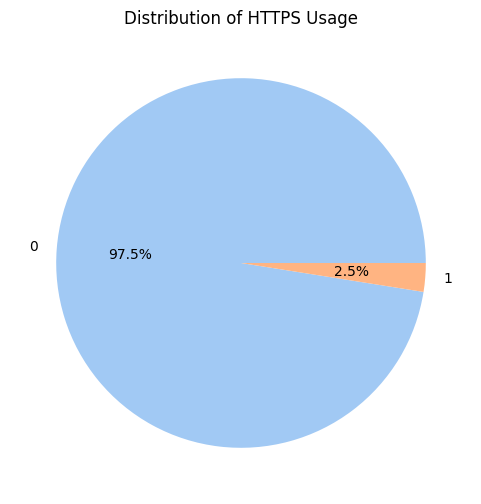

In [15]:
https_counts = df["has_https"].value_counts()

# Plot a pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    https_counts,
    labels=https_counts.index,
    autopct="%1.1f%%",
    colors=sns.color_palette("pastel"),
)
plt.title("Distribution of HTTPS Usage")
plt.show()


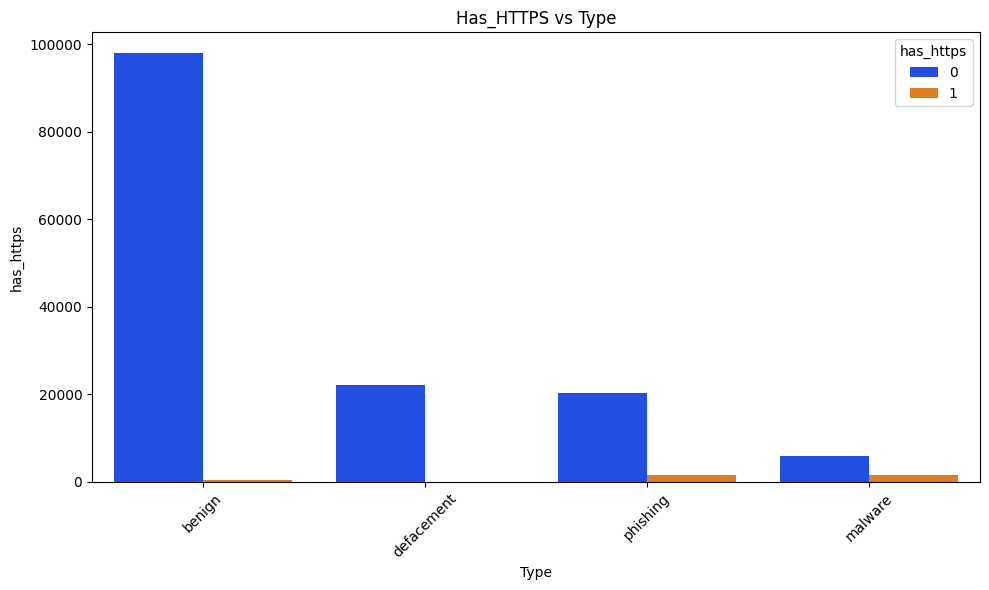

In [16]:
# Relationship between Type and HTTPS Usage
# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="type", hue="has_https", palette="bright")
plt.title("Has_HTTPS vs Type")
plt.xlabel("Type")
plt.ylabel("has_https")
plt.xticks(rotation=45)
plt.legend(title="has_https")
plt.tight_layout()
plt.show()


Most sites do not use HTTPS in our dataset and no correlation can be drawn between HTTPS usage and a benign URL. In actuality, having HTTPS for this dataset means that the URL has a higher probability of being malware or phishing.

In [17]:
# Count frequency of special characters
special_characters = ["@", "!", "?", "=", "-", "//", "#", ".", "+", "$", "*", "%", "&"]

def count_characters(url: str, character: str):
    return url.count(character)

for c in special_characters:
    df[c] = df["url"].apply(lambda url: count_characters(url, c))

df.head()

,url,type,category,url_length,domain,in_alexa_top_1000,has_https,@,!,?,=,-,//,#,.,+,$,*,%,&
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign,0,45,go.com,1,0,0,0,0,0,1,0,0,2,0,0,0,0,0
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign,0,107,onedio.com,0,0,0,0,0,0,10,1,0,1,0,0,0,0,0
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign,0,201,wwowus.net,0,0,0,0,2,6,1,0,0,7,0,0,0,0,5
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign,0,89,tinnhanh360.net,0,0,0,0,0,0,13,1,0,2,0,0,0,0,0
64374,kvha.org/,benign,0,9,kvha.org,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [18]:
# Digit to letter ratio in URL
def calculate_digit_to_letter_ratio(url):
    digits = sum(c.isdigit() for c in url)
    letters = sum(c.isalpha() for c in url)
    if letters == 0:
        ratio = 0
    else:
        ratio = digits / letters
    return ratio

df["digit_to_letter_ratio_url"] = df["url"].apply(calculate_digit_to_letter_ratio)

df.head()

,url,type,category,url_length,domain,in_alexa_top_1000,has_https,@,!,?,...,-,//,#,.,+,$,*,%,&,digit_to_letter_ratio_url
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign,0,45,go.com,1,0,0,0,0,...,1,0,0,2,0,0,0,0,0,0.000000
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign,0,107,onedio.com,0,0,0,0,0,...,10,1,0,1,0,0,0,0,0,0.070588
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign,0,201,wwowus.net,0,0,0,0,2,...,1,0,0,7,0,0,0,0,5,0.063694
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign,0,89,tinnhanh360.net,0,0,0,0,0,...,13,1,0,2,0,0,0,0,0,0.044776
64374,kvha.org/,benign,0,9,kvha.org,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.000000


In [19]:
# Letter to digit ratio in primary domain
df["digit_to_letter_ratio_domain"] = df["domain"].apply(calculate_digit_to_letter_ratio)

df.head()


,url,type,category,url_length,domain,in_alexa_top_1000,has_https,@,!,?,...,//,#,.,+,$,*,%,&,digit_to_letter_ratio_url,digit_to_letter_ratio_domain
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign,0,45,go.com,1,0,0,0,0,...,0,0,2,0,0,0,0,0,0.000000,0.000000
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign,0,107,onedio.com,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0.070588,0.000000
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign,0,201,wwowus.net,0,0,0,0,2,...,0,0,7,0,0,0,0,5,0.063694,0.000000
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign,0,89,tinnhanh360.net,0,0,0,0,0,...,1,0,2,0,0,0,0,0,0.044776,0.272727
64374,kvha.org/,benign,0,9,kvha.org,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.000000,0.000000


In [20]:
# Check if URL is an IP address
ip_pattern = (
    r"(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\."
    r"([01]?\d\d?|2[0-4]\d|25[0-5])\/)|"
    r"(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\."
    r"([01]?\d\d?|2[0-4]\d|25[0-5])\/)|"
    r"((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)"
    r"(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|"
    r"([0-9]+(?:\.[0-9]+){3}:[0-9]+)|"
    r"((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)"
)

def has_ip_address(url: str):
    # re.I = ignore case
    return int(re.search(ip_pattern, url, flags=re.I) is not None) 

df["has_ip"] = df["url"].apply(has_ip_address)


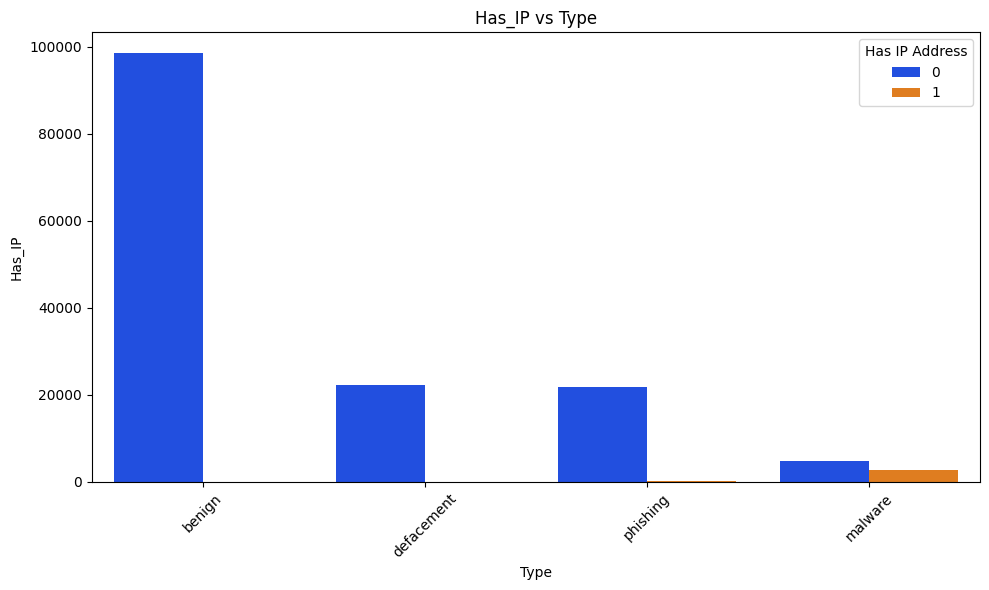

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="type", hue="has_ip", palette="bright")
plt.title("Has_IP vs Type")
plt.xlabel("Type")
plt.ylabel("Has_IP")
plt.xticks(rotation=45)
plt.legend(title="Has IP Address")
plt.tight_layout()
plt.show()


Having only an IP address has a strong correlation with being malware.

In [22]:
# Check if URL has been shortened by a service
shortening_pattern = (
    r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|"
    r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|"
    r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|"
    r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|"
    r"db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|"
    r"q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|"
    r"x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|"
    r"tr\.im|link\.zip\.net"
)


def has_shortening_service(url):
    return int(re.search(shortening_pattern, url, flags=re.I) is not None)

df["shortened"] = df["url"].apply(has_shortening_service)

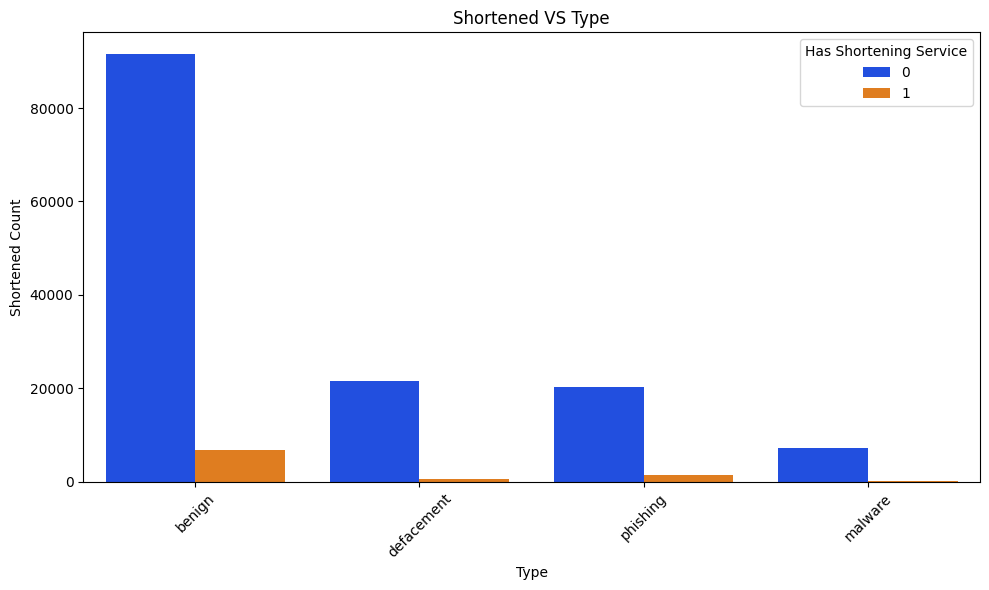

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="type", hue="shortened", palette="bright")
plt.title("Shortened VS Type")
plt.xlabel("Type")
plt.ylabel("Shortened Count")
plt.xticks(rotation=45)
plt.legend(title="Has Shortening Service")
plt.tight_layout()
plt.show()


There is a correlation with a URL being shortened and it also being benign.

In [24]:
# Prepare training data
y = df["category"]
X = df.drop(["type", "category", "url", "domain"], axis=1)

In [25]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=53)

In [26]:
# Check if saved model exists
if os.path.exists("svm_model_trained.pkl"):
    loaded_svm_model = pickle.load(open("svm_model_trained.pkl", "rb"))
else:
    loaded_svm_model = None

In [27]:
if not loaded_svm_model:
    # Prepare Model and Train it
    SVM_Model = SVC(gamma="auto")
    SVM_Model.fit(X_train, y_train)

    # Predict for train set
    y_train_pred = SVM_Model.predict(X_train)

    # Predict for test set
    y_pred = SVM_Model.predict(X_test)
else:
    # Predict for train set
    y_train_pred = loaded_svm_model.predict(X_train)

    # Predict for test set
    y_pred = loaded_svm_model.predict(X_test)

# Compute test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"Test Accuracy: {test_accuracy * 100}%")
print(f"Train Accuracy: {train_accuracy * 100}%")


Test Accuracy: 86.22444444444444%
Train Accuracy: 86.63809523809523%


In [28]:
# Save Model
if not loaded_svm_model:
    pickle.dump(SVM_Model, open("svm_model_trained.pkl", "wb"))

In [29]:
cm_svm = confusion_matrix(y_test, y_pred)

Text(50.722222222222214, 0.5, 'Actual Type')

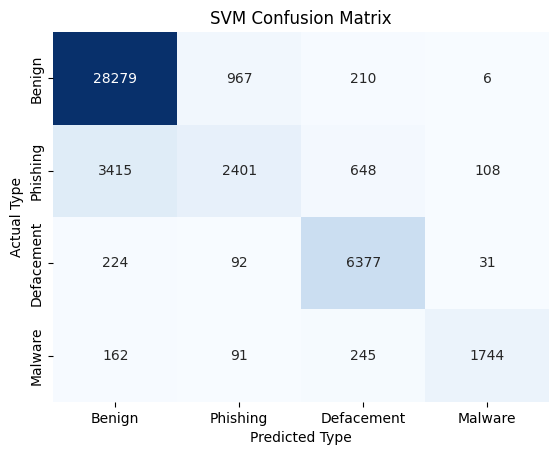

In [30]:
sns.heatmap(cm_svm, cmap="Blues", cbar=False, annot=True, fmt='.0f')
plt.xticks(np.arange(4) + 0.5, ["Benign", "Phishing", "Defacement", "Malware"])
plt.yticks(np.arange(4) + 0.5, ["Benign", "Phishing", "Defacement", "Malware"])
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Type")
plt.ylabel("Actual Type")


In [31]:
# 0 = Benign
# 1 = Phishing
# 2 = Defacement
# 3 = Malware
report = classification_report(y_test, y_pred, output_dict=True)
final_report = pd.DataFrame(report).transpose()
final_report

,precision,recall,f1-score,support
0,0.881515,0.959847,0.919015,29462.000000
1,0.676148,0.365338,0.474365,6572.000000
2,0.852540,0.948394,0.897916,6724.000000
3,0.923240,0.777877,0.844348,2242.000000
accuracy,0.862244,0.862244,0.862244,0.862244
macro avg,0.833361,0.762864,0.783911,45000.000000
weighted avg,0.849272,0.862244,0.847203,45000.000000


In [32]:
def compute_final_report(model_matrix):
    # Compute true/false positive/negative rates
    FP = model_matrix.sum(axis=0) - np.diag(model_matrix)
    FN = model_matrix.sum(axis=1) - np.diag(model_matrix)
    TP = np.diag(model_matrix)
    TN = model_matrix.sum() - (FP + FN + TP)

    data = {
        "Type": ["Benign", "Phishing", "Defacement", "Malware"],
        "False Positives": FP,
        "False Negatives": FN,
        "True Positives": TP,
        "True Negatives": TN,
    }

    rates = pd.DataFrame(data)

    # True positive rate
    rates["TPR"] = rates.apply(
        lambda row: row["True Positives"]
        / (row["True Positives"] + row["False Negatives"]),
        axis=1,
    )

    # True negative rate
    rates["TNR"] = rates.apply(
        lambda row: row["True Negatives"]
        / (row["True Negatives"] + row["False Positives"]),
        axis=1,
    )

    # Precision or positive predictive value
    rates["Precision"] = rates.apply(
        lambda row: row["True Positives"]
        / (row["True Positives"] + row["False Positives"]),
        axis=1,
    )

    # Negative predictive value
    rates["NPV"] = rates.apply(
        lambda row: row["True Negatives"]
        / (row["True Negatives"] + row["False Negatives"]),
        axis=1,
    )

    # Fall out or false positive rate
    rates["NPV"] = rates.apply(
        lambda row: row["False Positives"]
        / (row["False Positives"] + row["True Negatives"]),
        axis=1,
    )

    # False negative rate
    rates["FNR"] = rates.apply(
        lambda row: row["False Negatives"]
        / (row["True Positives"] + row["False Negatives"]),
        axis=1,
    )

    # False discovery rate
    FDR = FP / (TP + FP)
    rates["FDR"] = rates.apply(
        lambda row: row["False Positives"]
        / (row["True Positives"] + row["False Positives"]),
        axis=1,
    )

    return rates

In [33]:
compute_final_report(cm_svm).head()

,Type,False Positives,False Negatives,True Positives,True Negatives,TPR,TNR,Precision,NPV,FNR,FDR
0,Benign,3801,1183,28279,11737,0.959847,0.755374,0.881515,0.244626,0.040153,0.118485
1,Phishing,1150,4171,2401,37278,0.365338,0.970074,0.676148,0.029926,0.634662,0.323852
2,Defacement,1103,347,6377,37173,0.948394,0.971183,0.852540,0.028817,0.051606,0.147460
3,Malware,145,498,1744,42613,0.777877,0.996609,0.923240,0.003391,0.222123,0.076760


In [34]:
loaded_clf = None if not os.path.exists("clf_model_trained.pkl") else pickle.load(open("clf_model_trained.pkl", "rb"))

In [35]:
if not loaded_clf:
    clf = RandomForestClassifier(random_state=53)
    clf.fit(X_train, y_train)

    clf_y_train_pred = clf.predict(X_train)
    clf_y_pred = clf.predict(X_test)

else:
    clf_y_train_pred = loaded_clf.predict(X_train)
    clf_y_pred = loaded_clf.clf.predict(X_test)


In [36]:
clf_train_accuracy = accuracy_score(y_test, clf_y_pred)
clf_test_accuracy = accuracy_score(y_train, clf_y_train_pred)

print(f"Test Accuracy: {clf_test_accuracy * 100}%")
print(f"Train Accuracy: {clf_train_accuracy * 100}%")


Test Accuracy: 92.47714285714285%
Train Accuracy: 88.62222222222222%


In [37]:
# Save Model
if not loaded_svm_model:
    pickle.dump(SVM_Model, open("clf_model_trained.pkl", "wb"))

In [38]:
cm_clf = confusion_matrix(y_test, clf_y_pred)

Text(50.722222222222214, 0.5, 'Actual Type')

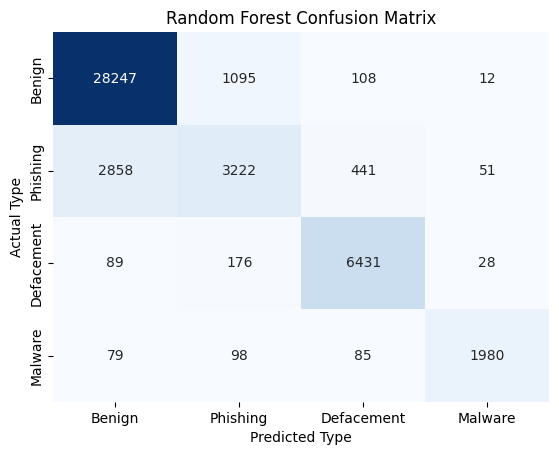

In [39]:
sns.heatmap(cm_clf, cmap="Blues", cbar=False, annot=True, fmt=".0f")
plt.xticks(np.arange(4) + 0.5, ["Benign", "Phishing", "Defacement", "Malware"])
plt.yticks(np.arange(4) + 0.5, ["Benign", "Phishing", "Defacement", "Malware"])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Type")
plt.ylabel("Actual Type")

In [40]:
# 0 = Benign
# 1 = Phishing
# 2 = Defacement
# 3 = Malware
report = classification_report(y_test, clf_y_pred, output_dict=True)
final_report = pd.DataFrame(report).transpose()
final_report

,precision,recall,f1-score,support
0,0.903239,0.958760,0.930172,29462.000000
1,0.701808,0.490262,0.577264,6572.000000
2,0.910262,0.956425,0.932772,6724.000000
3,0.956060,0.883140,0.918154,2242.000000
accuracy,0.886222,0.886222,0.886222,0.886222
macro avg,0.867842,0.822147,0.839591,45000.000000
weighted avg,0.877502,0.886222,0.878422,45000.000000


In [41]:
compute_final_report(cm_clf).head()

,Type,False Positives,False Negatives,True Positives,True Negatives,TPR,TNR,Precision,NPV,FNR,FDR
0,Benign,3026,1215,28247,12512,0.958760,0.805252,0.903239,0.194748,0.041240,0.096761
1,Phishing,1369,3350,3222,37059,0.490262,0.964375,0.701808,0.035625,0.509738,0.298192
2,Defacement,634,293,6431,37642,0.956425,0.983436,0.910262,0.016564,0.043575,0.089738
3,Malware,91,262,1980,42667,0.883140,0.997872,0.956060,0.002128,0.116860,0.043940


In [42]:
# Define Scaler for KNN
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [43]:
# KNN classifier load if exists else train and run
loaded_knn = (
    None
    if not os.path.exists("knn_model_trained.pkl")
    else pickle.load(open("knn_model_trained.pkl", "rb"))
)


In [44]:
if not loaded_knn:
    # Decide on best neighbor value
    neighbors = range(1, 40)
    train_acc = []
    test_acc = []

    for n in neighbors:
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(X_train, y_train)
        knn_y_train_pred = knn.predict(X_train)
        knn_y_pred = knn.predict(X_test)
        test_acc.append(accuracy_score(y_test, knn_y_pred))
        train_acc.append(accuracy_score(y_train, knn_y_train_pred))

In [46]:
plt.plot(neighbors, train_acc, label="training accuracy")
plt.plot(neighbors, test_acc, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("# of Neighbors")
plt.legend()

In [47]:
if not loaded_knn:
    knn = KNeighborsClassifier(n_neighbors=18)
    knn.fit(X_train, y_train)
    knn_y_train_pred = knn.predict(X_train)
    knn_y_pred = knn.predict(X_test)
else:
    knn_y_train_pred = loaded_knn.predict(X_train)
    knn_y_pred = loaded_knn.predict(X_test)
    

In [48]:
knn_train_accuracy = accuracy_score(y_test, knn_y_pred)
knn_test_accuracy = accuracy_score(y_train, knn_y_train_pred)

print(f"Test Accuracy: {knn_test_accuracy * 100}%")
print(f"Train Accuracy: {knn_train_accuracy * 100}%")


Test Accuracy: 87.93333333333334%
Train Accuracy: 87.30666666666667%


In [49]:
# Save Model
if not loaded_knn:
    pickle.dump(knn, open("knn_model_trained.pkl", "wb"))


In [50]:
cm_knn = confusion_matrix(y_test, knn_y_pred)

Text(50.722222222222214, 0.5, 'Actual Type')

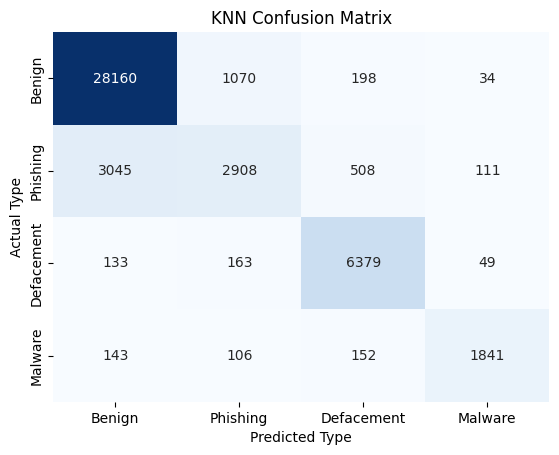

In [51]:
sns.heatmap(cm_knn, cmap="Blues", cbar=False, annot=True, fmt=".0f")
plt.xticks(np.arange(4) + 0.5, ["Benign", "Phishing", "Defacement", "Malware"])
plt.yticks(np.arange(4) + 0.5, ["Benign", "Phishing", "Defacement", "Malware"])
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Type")
plt.ylabel("Actual Type")


In [52]:
# 0 = Benign
# 1 = Phishing
# 2 = Defacement
# 3 = Malware
report = classification_report(y_test, knn_y_pred, output_dict=True)
final_report = pd.DataFrame(report).transpose()
final_report

,precision,recall,f1-score,support
0,0.894508,0.955807,0.924142,29462.000000
1,0.684719,0.442483,0.537573,6572.000000
2,0.881443,0.948691,0.913831,6724.000000
3,0.904668,0.821142,0.860884,2242.000000
accuracy,0.873067,0.873067,0.873067,0.873067
macro avg,0.841334,0.792031,0.809108,45000.000000
weighted avg,0.862423,0.873067,0.862994,45000.000000


In [53]:
compute_final_report(cm_knn).head()

,Type,False Positives,False Negatives,True Positives,True Negatives,TPR,TNR,Precision,NPV,FNR,FDR
0,Benign,3321,1302,28160,12217,0.955807,0.786266,0.894508,0.213734,0.044193,0.105492
1,Phishing,1339,3664,2908,37089,0.442483,0.965156,0.684719,0.034844,0.557517,0.315281
2,Defacement,858,345,6379,37418,0.948691,0.977584,0.881443,0.022416,0.051309,0.118557
3,Malware,194,401,1841,42564,0.821142,0.995463,0.904668,0.004537,0.178858,0.095332


## Results
Interpreting the final report for SVM shows a precision of 92% for Malware meaning that the model is certain a URL is Malware 92% of the time. The next highest precision is Benign URLs with an 88% precision. Recall represents the detection rate of the model i.e. how many of the True Positives were detected by category. For recall, the leading 2 are Benign and Defacement with 96% and 94.8% respectively. F1-score represents an average between precision and recall and represents a scaled accuracy between the types. Here, Benign is the leader with 91.9% accuracy followed closely by Defacement with 89.8% and Malware with 84.4%. Phishing showed the worst overall performance with a F1-score of 47.4%.

Interpreting the SVM matrix, we can see that Benign URLS had the highest chance of being correctly identified at 96% recall rate followed by Defacement at 94.8%. Additionally, our classification heuristics correctly identified a URL not being malware with a true negative rate of 99.7%. The weakest performance was from Phishing with a 36.5% True positive rate followed by Malware's TPV. The bulk of the misidentification in the case of Phishing was from false negatives. Phishing had the highest false negative rate of 63% followed by malware of 22%. Defacement and Benign types had a comparatively insignificant FNR of about 4-5%. The highest negative predictive value was Benign which means that the model is most confident when describing a URL as not Benign.

The random forest model showed a max of 95% precision with the next highest being for Defacement URLs with a precision of 91%. The highest recall values were from Benign and Defacement, both with 95% recall rates. The same two types were also tied for top F1-score with a value of 93%. The worst performers for F1-score was Phishing with 57.8%. Random forest showed a high TNR across all types except Benign, ranging from the lowest of Phishing at 96.4% to Malware with 99.8%. Phishing had the highest FNR of 50.1% again with the next significant one being Malware with 11.7% followed by Benign and Defacement with 4% FNRs each.

KNN showed a max precision of 90% for Malware with Defacement and Benign having precisions of 88% and 89% respectively with a neighbor count of 18. 18 was chosen because any higher value would have closed the gap in accuracy but at the cost of significant overall accuracy. The highest TPR recorded was 95% by Benign types. The highest TNR was Malware with 99.5% with the same pattern as the previous 2 models occurring for Phishing and Defacement. 

Overall, random forest performed the best followed by SVM and KNN showing higher precision, TNRs, and TPRs across the board. KNN performed better than SVM in some categories but also lost in some such that the differences are negligible between KNN and SVM. 

## Conclusion

In conclusion, based on the evaluation of the aforementioned algorithms, random forest emerged as the most effective model between these 3 models. Random forest exhibited superior precision, recall, and F1-score metrics across all categories and all URL types. However, like the other models, random forest displayed a weakness in identifying phishing URLs with an F1-score of 57.8%. Based on the data, all three models did correctly identify a benign versus malicious URL with about a 99% rate meaning that though classifying URLs into specific malicious categories still prove difficult, the models tested performed well when differentiating a malicious URL from the three malicious categories from a harmless benign URL. What this means in practice is that these models would perform well in URL identification tasks when the problem is binary in nature, but has the risk of falsely categorizing a malicious URL when told to do so. Future research could explore additional models and heuristics to enhance the accuracy of these metrics.

## References
https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal

https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset

https://www.kaggle.com/code/salemjadroun/malicious-urls-machine-learning-with-91-46-acc/notebook

https://dev.to/ruthvikraja_mv/identifying-suspicious-urls-using-supervised-learning-and-lexical-analysis-215h
